# Glass Type Classification with Deep Learning

### Loading and exploring the shape of the dataset

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('glass.csv')
features = df.columns[:-1].tolist()
print(features)
print(df.shape)

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
(214, 10)


The dataset consists of 214 observations

In [7]:
df.head(15)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [8]:
df.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [6]:
df['Type'].value_counts()

Type
2    76
1    70
7    29
3    17
5    13
6     9
Name: count, dtype: int64

In [3]:


X = df.drop('Type', axis=1) 
y = df['Type']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scaling and transformation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_scaled)


X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = X_train_tensor.shape[1]
hidden_dim = 512
output_dim = len(np.unique(y_encoded))

model = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


MLP(
  (fc1): Linear(in_features=6, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=6, bias=True)
)

In [ ]:
# Training loop
num_epochs = 100
early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0

# Lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_recalls = []
val_precisions = []

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_losses.append(loss.item())
    

    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    precision = precision_score(all_targets, all_preds, average='macro')
    
    val_accuracies.append(accuracy)
    val_f1_scores.append(f1)
    val_recalls.append(recall)
    val_precisions.append(precision)
    
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss}, Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}, Precision: {precision}')



In [5]:

model.load_state_dict(torch.load('best_model.pt'))

# Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

accuracy = 100 * correct / total
f1 = f1_score(all_targets, all_preds, average='macro')
recall = recall_score(all_targets, all_preds, average='macro')
precision = precision_score(all_targets, all_preds, average='macro')


Epoch [1/100], Loss: 0.6394459009170532, Val Loss: 0.8161449615250934, Accuracy: 0.813953488372093, F1 Score: 0.7605204400600821, Recall: 0.7408008658008658, Precision: 0.8513227513227513
Epoch [2/100], Loss: 0.7078919410705566, Val Loss: 0.9193001550368287, Accuracy: 0.7674418604651163, F1 Score: 0.7739567621920563, Recall: 0.7606421356421356, Precision: 0.825925925925926
Epoch [3/100], Loss: 0.7870150208473206, Val Loss: 0.8668138753538105, Accuracy: 0.7906976744186046, F1 Score: 0.772238727140688, Recall: 0.7693001443001443, Precision: 0.7904946904946906
Epoch [4/100], Loss: 0.6146475672721863, Val Loss: 0.6262529735368761, Accuracy: 0.8372093023255814, F1 Score: 0.8593896173606318, Recall: 0.840007215007215, Precision: 0.9004273504273503
Epoch [5/100], Loss: 0.8205491900444031, Val Loss: 0.8555138549682769, Accuracy: 0.8372093023255814, F1 Score: 0.8205448201825014, Recall: 0.7963564213564213, Precision: 0.8715811965811966
Epoch [6/100], Loss: 0.610707700252533, Val Loss: 0.8957815

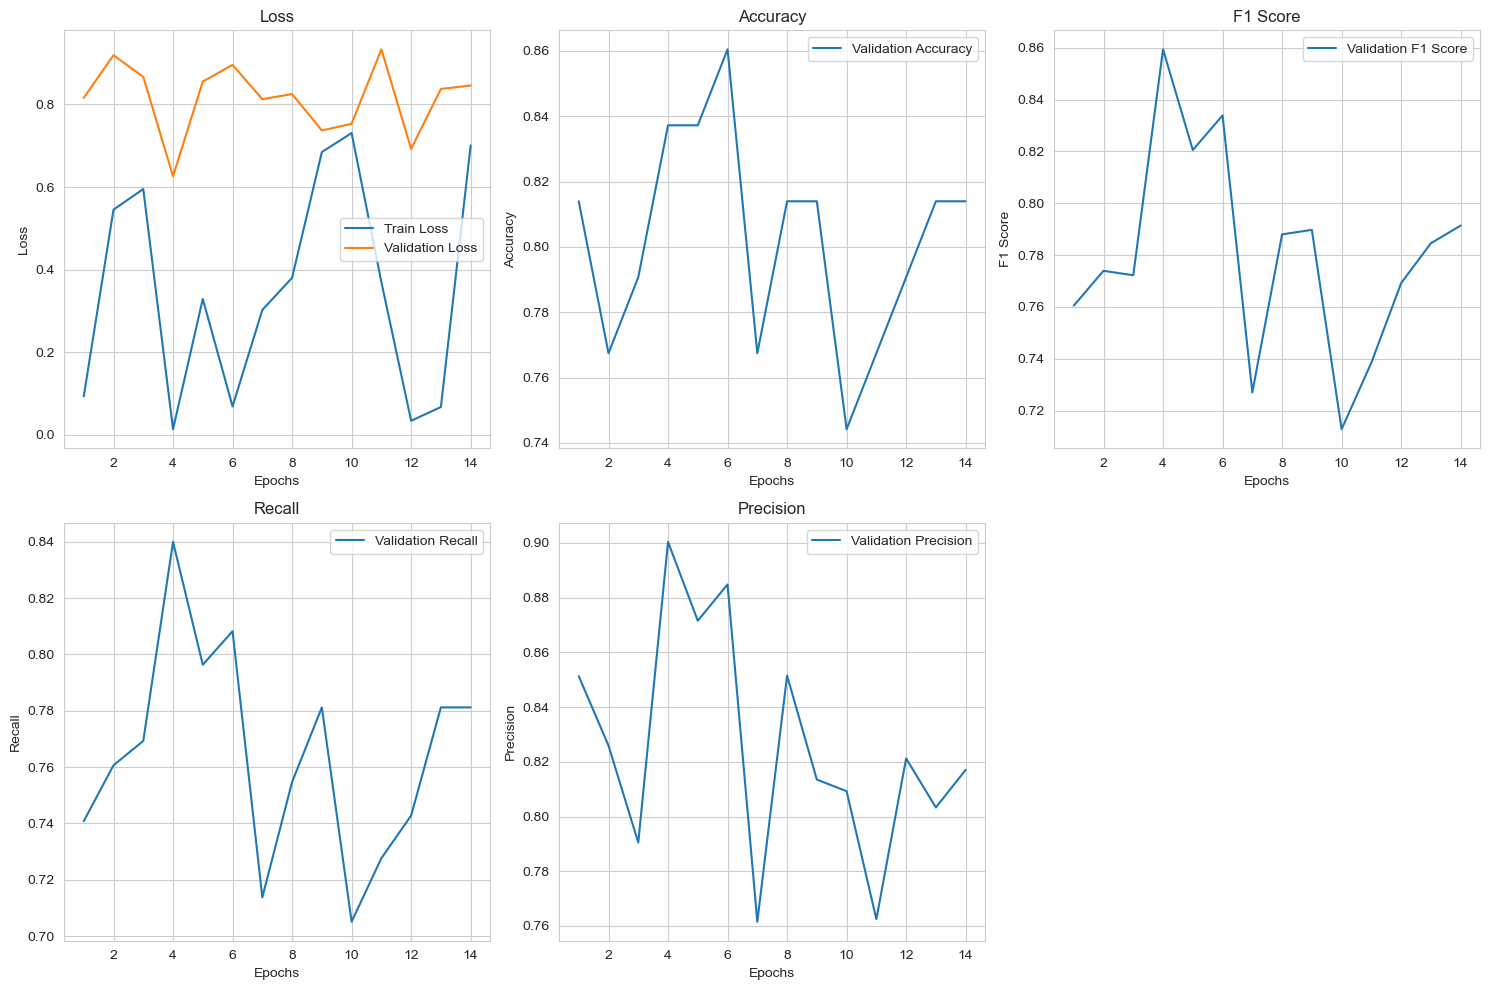

In [12]:

print(f'Test Accuracy: {accuracy:.2f}%')
print(f'Test F1 Score: {f1:.2f}')
print(f'Test Recall: {recall:.2f}')
print(f'Test Precision: {precision:.2f}')

# Function to plot metrics
def plot_metrics(train_losses, val_losses, val_accuracies, val_f1_scores, val_recalls, val_precisions):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 3, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 3, 3)
    plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.subplot(2, 3, 4)
    plt.plot(epochs, val_recalls, label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    
    plt.subplot(2, 3, 5)
    plt.plot(epochs, val_precisions, label='Validation Precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


plot_metrics(train_losses, val_losses, val_accuracies, val_f1_scores, val_recalls, val_precisions)